In [1]:
import numpy as np #untuk komputasi numerik
import os #interaksi dengan sistem operasi.
import seaborn as sn    #visualisasi data
import matplotlib.pyplot as plt #visualisasi data
import pandas as pd #pengelolaan data
import cv2 #show image
import keras #model deep learning
import datetime
import tensorflow as tf #model deep learning

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc #evaluasi model
from sklearn.utils import shuffle #mengacak urutan
from sklearn.preprocessing import LabelBinarizer #mengubah label ke bentuk angka
from sklearn.model_selection import StratifiedKFold, train_test_split
from tqdm import tqdm #display the progress of our Python code
from imblearn.under_sampling import RandomUnderSampler, NearMiss #resampling data
from keras.layers import Conv2D, Flatten, Input, BatchNormalization, DepthwiseConv2D, GlobalAveragePooling2D, Activation, Dropout, Dense
from keras.models import Model #membuat model dl
# menghentikan training apabila loss semakin naik dan akurasi tidak meningkat
# menyimpan model hasil tarining
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.backend import clear_session

import matplotlib
matplotlib.use("Agg")
%matplotlib inline

In [2]:
class_names = ['Karacadag', 'Jasmine', 'Ipsala', 'Basmati', 'Arborio']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

num_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def load_data():

    datasets = [
                'gdrive/My Drive/Penelitian Andyka/data/train',
                'gdrive/My Drive/Penelitian Andyka/data/test'
                ]
    output = []

    # Iterasi pada training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))
        print(dataset)

        # Iterasi setiap folder yang sesuai dengan kategori
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            # Iterasi setiap gambar pada setiap folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # mendapatkan oath setiap gambar
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # baca, konversi ke RGB, konversi ukuran
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # menambahkan gambar dan label yang sesuai ke output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [5]:
((train_images, train_labels), (test_images, test_labels)) = load_data()

Loading gdrive/My Drive/Penelitian Andyka/data/train
gdrive/My Drive/Penelitian Andyka/data/train


100%|██████████| 1600/1600 [00:26<00:00, 61.34it/s] 


Loading gdrive/My Drive/Penelitian Andyka/data/test
gdrive/My Drive/Penelitian Andyka/data/test


100%|██████████| 400/400 [00:05<00:00, 77.14it/s] 


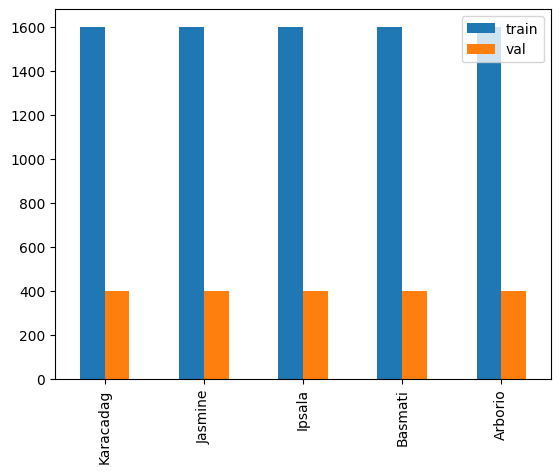

In [ ]:
# memvisualisasikan data
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
              'val': test_counts},
             index=class_names).plot.bar()
plt.show()

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [7]:
def depthwise_separable_conv(x, filters, kernel_size, strides):
    x = DepthwiseConv2D(kernel_size, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Conv2D(filters, kernel_size=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

# Define the MobileNetV1 architecture
def create_mobilenet_v1(input_shape=(224, 224, 3), num_classes=5):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(32, kernel_size=3, strides=(2, 2), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Depthwise Separable Convolutions
    x = depthwise_separable_conv(x, 64, 3, 1)
    x = depthwise_separable_conv(x, 128, 3, 2)
    x = depthwise_separable_conv(x, 128, 3, 1)
    x = depthwise_separable_conv(x, 256, 3, 2)
    x = depthwise_separable_conv(x, 256, 3, 1)
    x = depthwise_separable_conv(x, 512, 3, 2)

    # Additional Depthwise Separable Convolutions
    for _ in range(5):
        x = depthwise_separable_conv(x, 512, 3, 1)

    # Final layers
    x = depthwise_separable_conv(x, 1024, 3, 2)
    x = depthwise_separable_conv(x, 1024, 3, 1)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x, name='mobilenet_v1')
    return model

# Create the MobileNetV1 model
model = create_mobilenet_v1()

# Print the model summary
model.summary()

Model: "mobilenet_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 32)      320       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)     

In [8]:
from keras.applications import MobileNet

# Load the MobileNetV1 model pre-trained on ImageNet (without top classification layer)
base_model = MobileNet(input_shape = (224, 224, 3), weights='imagenet', include_top=False)
base_model.trainable = False

# Add custom classification layers on top of MobileNetV1
def ars_mobilenet():
  x = GlobalAveragePooling2D()(base_model.output)
  x = Dense(1024, activation='relu')(x)
  predictions = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  return model

model=ars_mobilenet()
model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                              

In [9]:
def model_name(k):
  return 'model_'+str(k)+'.h5'

val_acc=[]
val_precision=[]
val_recall=[]
val_f1score=[]

akurasi=[]

CV=[]
waktu=[]

LOSS=[]
VAL_LOSS=[]
ACCURACY=[]
VAL_ACCURACY=[]

fold_var = 1
max_epoch = 100
bs = 10
lr = 0.0003
moment = 0.9

save_dir = 'gdrive/My Drive/Penelitian Andyka/'

In [10]:
kf = StratifiedKFold(n_splits=5)
kf.get_n_splits(train_images, train_labels)

5

In [ ]:
for train_index, val_index in kf.split(train_images, train_labels):
  print("---------- FOLD KE- {} ----------".format(fold_var))
  x_train, y_train = train_images[train_index], train_labels[train_index]
  x_val, y_val = train_images[val_index], train_labels[val_index]

  y_train = to_categorical(y_train)
  y_val = to_categorical(y_val)

  model = ars_mobilenet()

  model.compile(optimizer=SGD(learning_rate=lr, momentum=moment), loss='binary_crossentropy',metrics=['accuracy'])

  project_name = 'model'
  save_model = model_name(fold_var)
  simpan_bobot = os.path.join(save_dir, project_name, save_model)
  if os.path.exists(os.path.join(save_dir, project_name)) == False:
    os.makedirs(os.path.join(save_dir, project_name))

  # min_delta (perubahan minimal), patience (jumlah epoch tanpa perbaikan)
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
  checkpoint = ModelCheckpoint(simpan_bobot,monitor='val_accuracy',save_best_only=True, mode='max', verbose=1)
  callbacks_list = [early_stop, checkpoint]

  #training
  mulai = datetime.datetime.now()
  hist = model.fit(x_train, y_train, batch_size=bs, epochs=max_epoch, callbacks=callbacks_list,
                   validation_data=(x_val, y_val))
  selesai = datetime.datetime.now()

  result = model.evaluate(x_train, y_train, batch_size=bs)
  result = dict(zip(model.metrics_names, result))

  prediksi = model.predict(x_val)
  y_prediksi = np.argmax(prediksi, axis=1)
  y_val = np.argmax(y_val, axis=1)
  print(classification_report(y_val, y_prediksi, target_names=class_names))
  jam = selesai - mulai
  print('Waktu Pelatihan Data : ', jam)
  waktu.append(jam)

  acc = accuracy_score(y_val, y_prediksi)
  prec = precision_score(y_val, y_prediksi, average='weighted')
  rec = recall_score(y_val, y_prediksi, average='weighted')
  f1score = f1_score(y_val, y_prediksi, average='weighted')

  val_acc.append(result['accuracy'])
  val_precision.append(prec)
  val_recall.append(rec)
  val_f1score.append(f1score)
  akurasi.append(acc)

  LOSS.append(hist.history['loss'])
  ACCURACY.append(hist.history['accuracy'])
  VAL_LOSS.append(hist.history['val_loss'])
  VAL_ACCURACY.append(hist.history['val_accuracy'])

  CV.append('CV-'+str(fold_var))
  clear_session()
  fold_var+=1

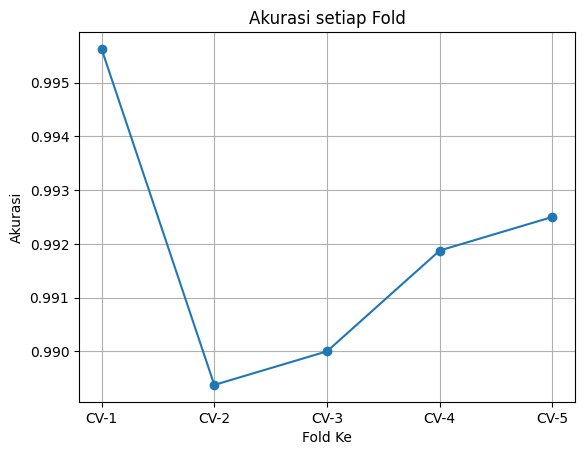

In [ ]:
fig = plt.figure()
plt.plot(CV, akurasi, marker='o')
plt.title('Akurasi setiap Fold')
plt.xlabel('Fold Ke')
plt.ylabel('Akurasi')
plt.grid()
plt.show()

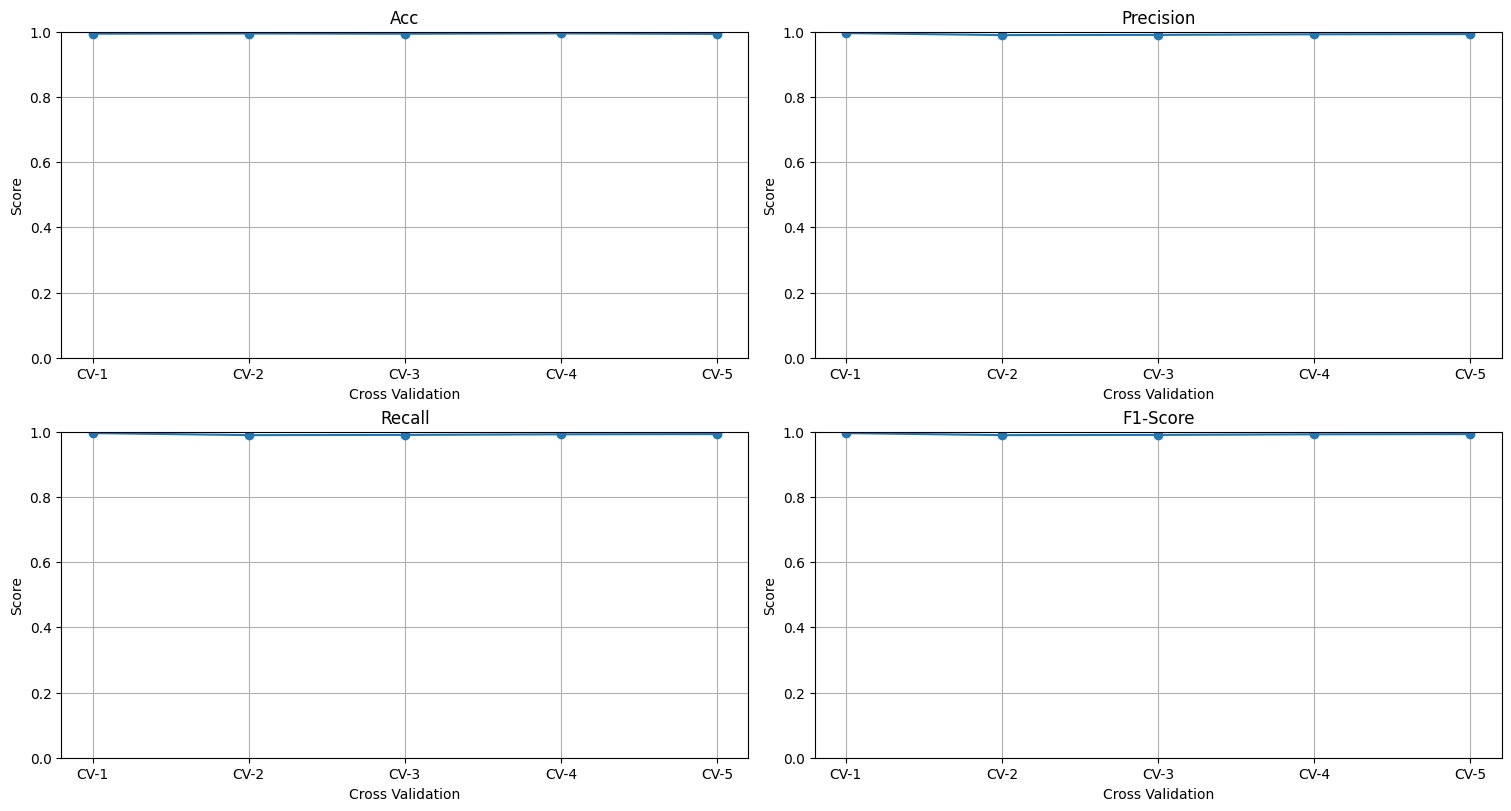

In [ ]:
fig, axs = plt.subplots(2,2,constrained_layout=True, figsize=(15,8))

axs[0,0].plot(CV, val_acc, marker='o')
axs[0,0].set_title('Acc')
axs[0,0].set_xlabel('Cross Validation')
axs[0,0].set_ylabel('Score')
axs[0,0].set_ylim((0., 1))
axs[0,0].grid()

axs[0,1].plot(CV, val_precision, marker='o')
axs[0,1].set_title('Precision')
axs[0,1].set_xlabel('Cross Validation')
axs[0,1].set_ylabel('Score')
axs[0,1].set_ylim((0., 1))
axs[0,1].grid()

axs[1,0].plot(CV, val_recall, marker='o')
axs[1,0].set_title('Recall')
axs[1,0].set_xlabel('Cross Validation')
axs[1,0].set_ylabel('Score')
axs[1,0].set_ylim((0., 1))
axs[1,0].grid()

axs[1,1].plot(CV, val_f1score, marker='o')
axs[1,1].set_title('F1-Score')
axs[1,1].set_xlabel('Cross Validation')
axs[1,1].set_ylabel('Score')
axs[1,1].set_ylim((0., 1))
axs[1,1].grid()

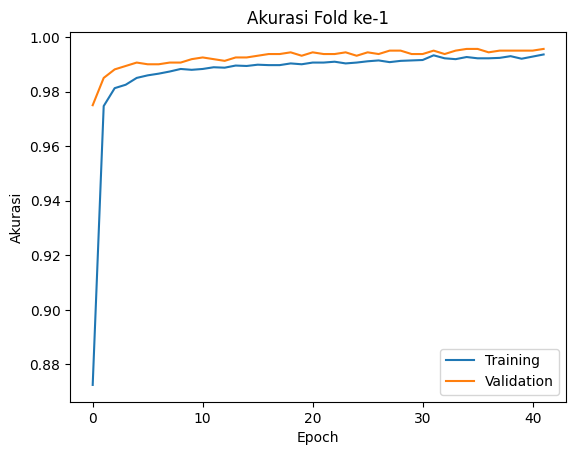

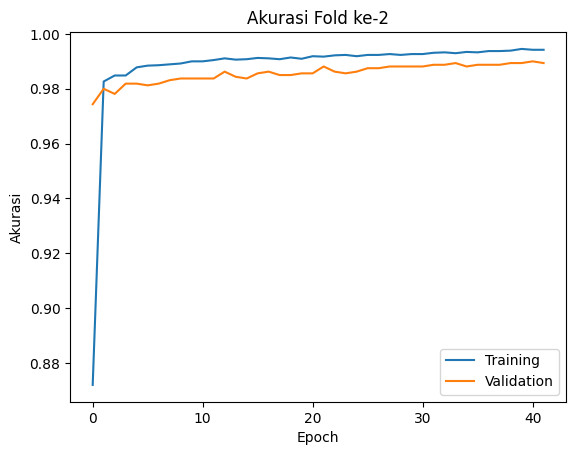

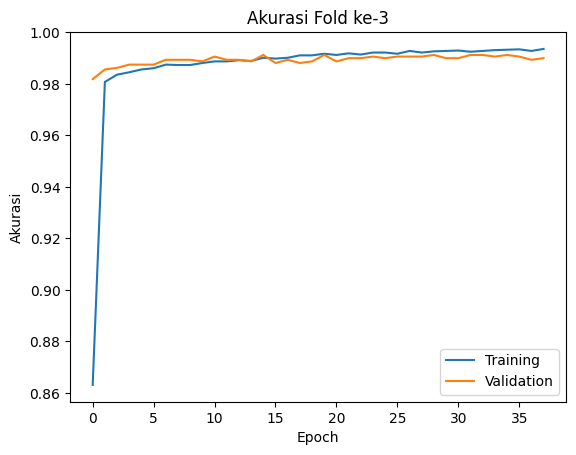

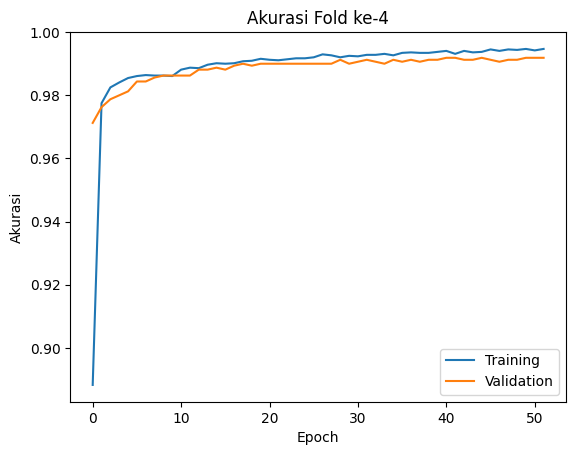

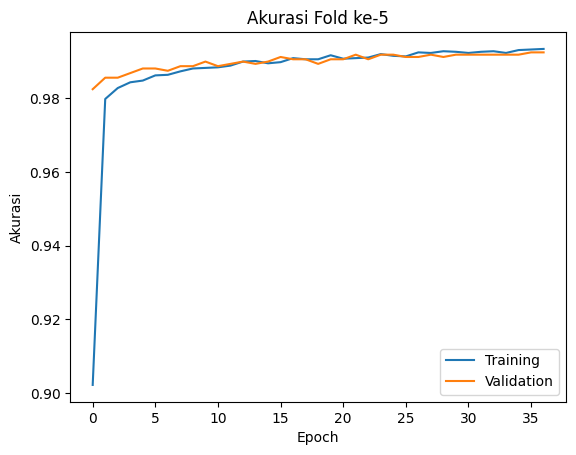

In [ ]:
for i in range(5):
    plt.plot(ACCURACY[i], label='Training')
    plt.plot(VAL_ACCURACY[i], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.title('Akurasi Fold ke-'+str(i+1))
    plt.legend()
    plt.show()

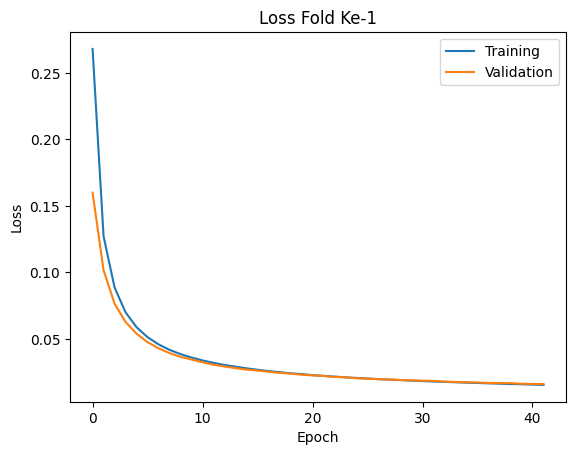

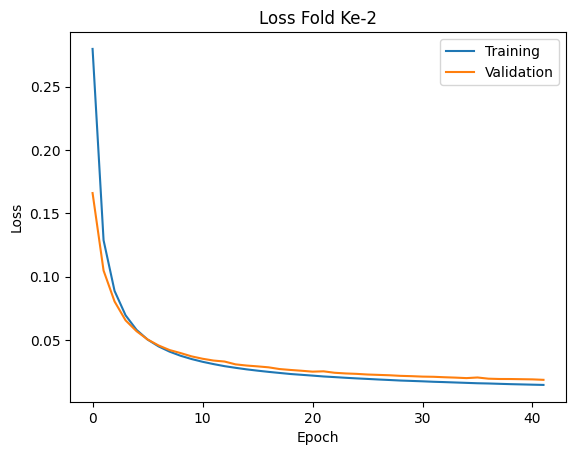

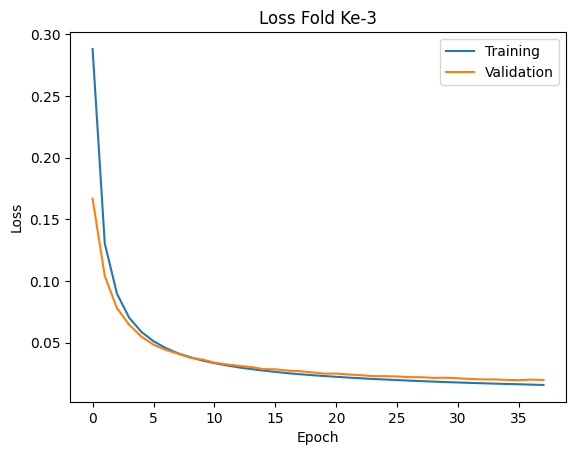

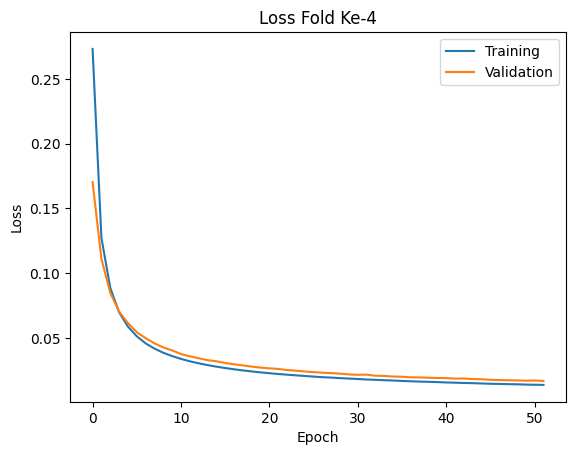

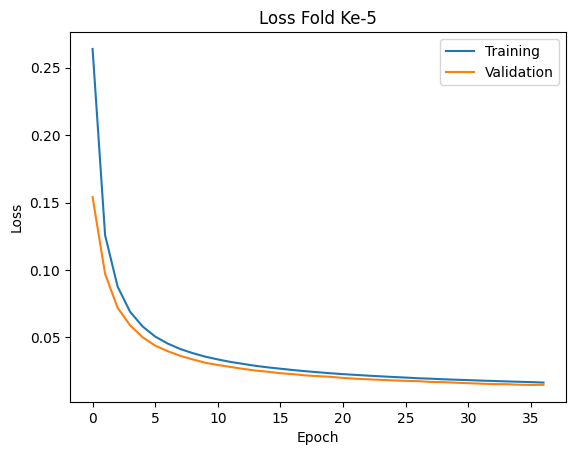

In [ ]:
for i in range(5):
    plt.plot(LOSS[i], label='Training')
    plt.plot(VAL_LOSS[i], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Fold Ke-'+str(i+1))
    plt.legend()
    plt.show()

In [ ]:
def bestK():
  a = max([(v,i) for i,v in enumerate(akurasi)])
  return str(int(a[1])+1)

In [ ]:
from keras.models import load_model
model = load_model(save_dir+'model/model_'+bestK()+'.h5')

In [ ]:
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_labels, y_pred, target_names=class_names))

63/63 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

   Karacadag       1.00      0.99      0.99       400
     Jasmine       0.99      1.00      1.00       400
      Ipsala       1.00      1.00      1.00       400
     Basmati       1.00      0.99      1.00       400
     Arborio       0.99      0.99      0.99       400

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [ ]:
acc_test = accuracy_score(test_labels, y_pred)
prec_test = precision_score(test_labels, y_pred, average='weighted')
rec_test = recall_score(test_labels, y_pred, average='weighted')
f1score_test = f1_score(test_labels, y_pred, average='weighted')

print('Acc Test : ', acc_test)
print('Prec Test : ', prec_test)
print('Rec Test : ', rec_test)
print('F1-Score Test : ', f1score_test)

Acc Test :  0.9955
Prec Test :  0.9955384124020343
Rec Test :  0.9955
F1-Score Test :  0.9955023983388913


<Axes: >

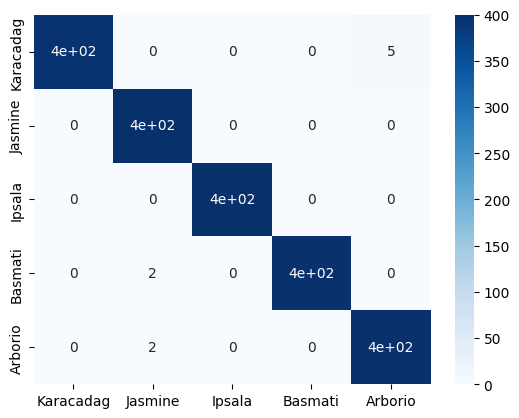

In [ ]:
cm = confusion_matrix(test_labels, y_pred)
sn.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [ ]:
cm

array([[395,   0,   0,   0,   5],
       [  0, 400,   0,   0,   0],
       [  0,   0, 400,   0,   0],
       [  0,   2,   0, 398,   0],
       [  0,   2,   0,   0, 398]])

In [ ]:
def display_image(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        index = np.random.randint(images.shape[0])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[index])
        plt.ylabel(class_names[y_pred[index]])
        plt.xlabel(class_names[test_labels[index]])
    plt.show()

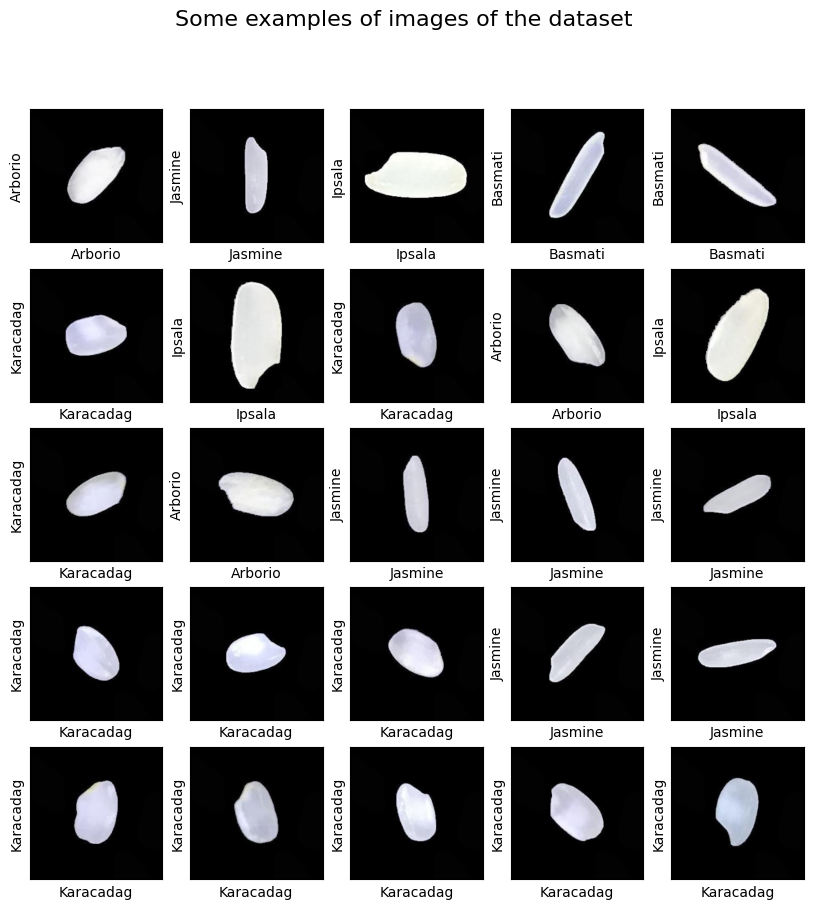

In [ ]:
display_image(class_names, test_images, test_labels)

In [ ]:
from google.colab import files
def testing():
  uploades = files.upload()

  for image in uploades.keys():
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE)
    img = img/255.0
    img = np.array(img, dtype = 'float32')
    img = np.expand_dims(img, axis=0)
    result=model.predict(img, verbose=0)
    predicted_class_name = class_names[np.argmax(result)]
    kelas = os.path.basename(image).split('/')[-1].split()[0]
    plt.ylabel(kelas)
    plt.xlabel(predicted_class_name)
    plt.show()

Saving Karacadag (133).jpg to Karacadag (133).jpg


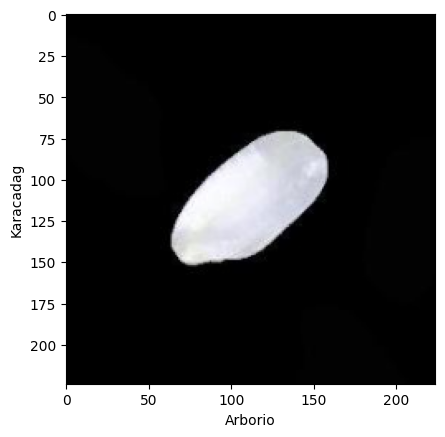

In [ ]:
testing()

Saving basmati (891).jpg to basmati (891).jpg


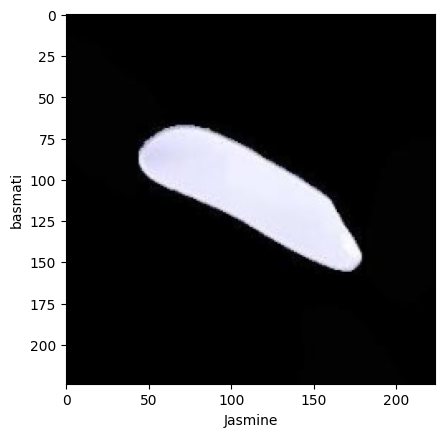

In [ ]:
testing()

Saving Arborio (441).jpg to Arborio (441).jpg


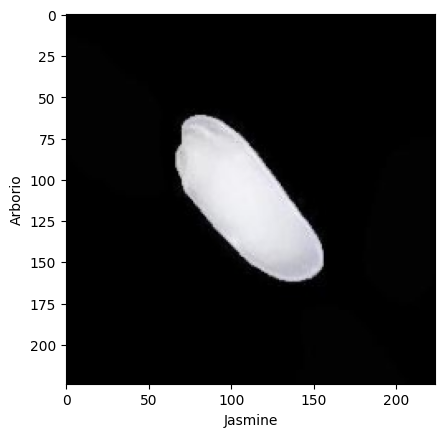

In [ ]:
testing()

Saving Ipsala (9995).jpg to Ipsala (9995).jpg


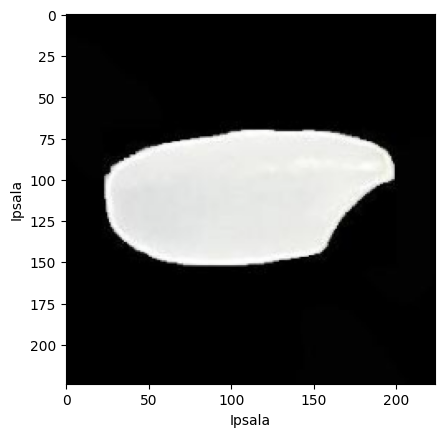

In [ ]:
testing()

Saving Arborio (9993).jpg to Arborio (9993).jpg


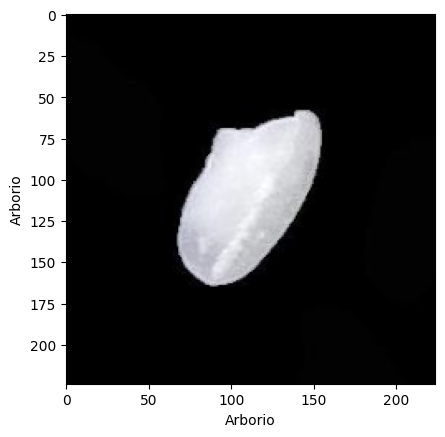

In [ ]:
testing()

Saving Jasmine (2581).jpg to Jasmine (2581).jpg


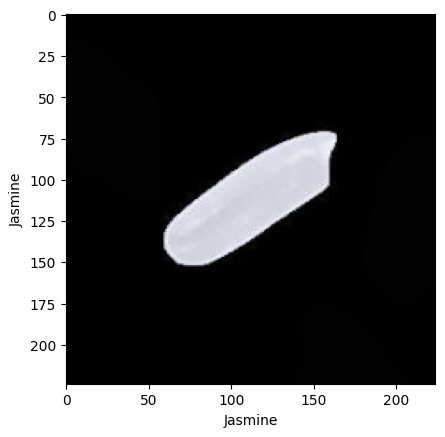

In [ ]:
testing()